1. Data Preprocessing

In [2]:
import pandas as pd


# Load the dataset
file_path = 'data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')
data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [3]:
# 1.1 Handling Missing Values

# Check for missing values
missing_values = data.isnull().sum()
print(f'Missing values:\n: {missing_values}\n\n')



# Fill missing values in 'CustomerID' and 'Description'
data['CustomerID'] = data['CustomerID'].fillna('Unknown Customer')
data['Description'] = data['Description'].fillna('No Description')

# Re-check for missing values
missing_values_after = data.isnull().sum()

print("Missing values after filling:\n", missing_values_after)

Missing values:
: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Missing values after filling:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [4]:
#1.2 Convert Data Types

#1). Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
# Check for NaT values in 'InvoiceDate'
nat_counts = data['InvoiceDate'].isna().sum()
print("Number of NaT values in 'InvoiceDate':", nat_counts)


#2). Convert InvoiceNo to string
data['InvoiceNo'] = data['InvoiceNo'].astype(str)

#3). Convert CustomerID to string
data['CustomerID'] = data['CustomerID'].astype(str)

Number of NaT values in 'InvoiceDate': 0


In [5]:
original_data = data.copy()
original_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [6]:
# 1.3 Special treatment for InvoiceNo that starts with 'C':


# Separate cancellations and potential original transactions
cancellations = data[data['InvoiceNo'].str.startswith('C')]
originals = data[~data['InvoiceNo'].str.startswith('C')]

# Create a set of tuples (StockCode, CustomerID, Quantity) for cancellations and originals
cancel_set = set(cancellations.apply(lambda row: (row['StockCode'], row['CustomerID'], -row['Quantity']), axis=1))
original_set = set(originals.apply(lambda row: (row['StockCode'], row['CustomerID'], row['Quantity']), axis=1))

# Find intersection
matches = cancel_set.intersection(original_set)

# Remove matched transactions from the original DataFrame
# First, flag rows to be removed
data['to_remove'] = data.apply(lambda row: (row['StockCode'], row['CustomerID'], row['Quantity']) in matches or
(row['StockCode'], row['CustomerID'], -row['Quantity']) in matches, axis=1)

# Then, remove these rows
data_cleaned = data[~data['to_remove']]

# Drop the 'to_remove' column
data_cleaned = data_cleaned.drop(columns=['to_remove'])

# Check if there are any values left in the 'InvoiceNo' column starting with 'C'
invoices_start_with_c = data_cleaned['InvoiceNo'].astype(str).str.startswith('C').any()
print("Are there any InvoiceNo values starting with 'C' left in the data?:", invoices_start_with_c)

# Remove these rows with 'C' in 'InvoiceNo' that indicate cancellations of earlier transactions

transac_data = data_cleaned[~data_cleaned['InvoiceNo'].astype(str).str.startswith('C')]

# Check again if there are any remaining values in the 'InvoiceNo' column starting with 'C'
invoices_start_with_c_remaining = transac_data['InvoiceNo'].astype(str).str.startswith('C').any()
print("Are there any InvoiceNo values starting with 'C' in the cleaned data?:", invoices_start_with_c_remaining)


Are there any InvoiceNo values starting with 'C' left in the data?: True
Are there any InvoiceNo values starting with 'C' in the cleaned data?: False


In [7]:
#1.4 Handling Negative Values in Quantity and UnitPrice

# Remove rows with negative Quantity
transac_data = transac_data[transac_data['Quantity'] >= 0]

# Check if there are any negative values left in the 'Quantity' column
negative_quantities = transac_data['Quantity'].lt(0).any()
print("Are there any negative values left in the 'Quantity' column?:", negative_quantities)

# Remove rows with negative UnitPrice
transac_data = transac_data[transac_data['UnitPrice'] >= 0]

# Check if there are any negative values left in the 'UnitPrice' column
negative_unit_prices = transac_data['UnitPrice'].lt(0).any()
print("Are there any negative values left in the 'UnitPrice' column?:", negative_unit_prices)

Are there any negative values left in the 'Quantity' column?: False
Are there any negative values left in the 'UnitPrice' column?: False


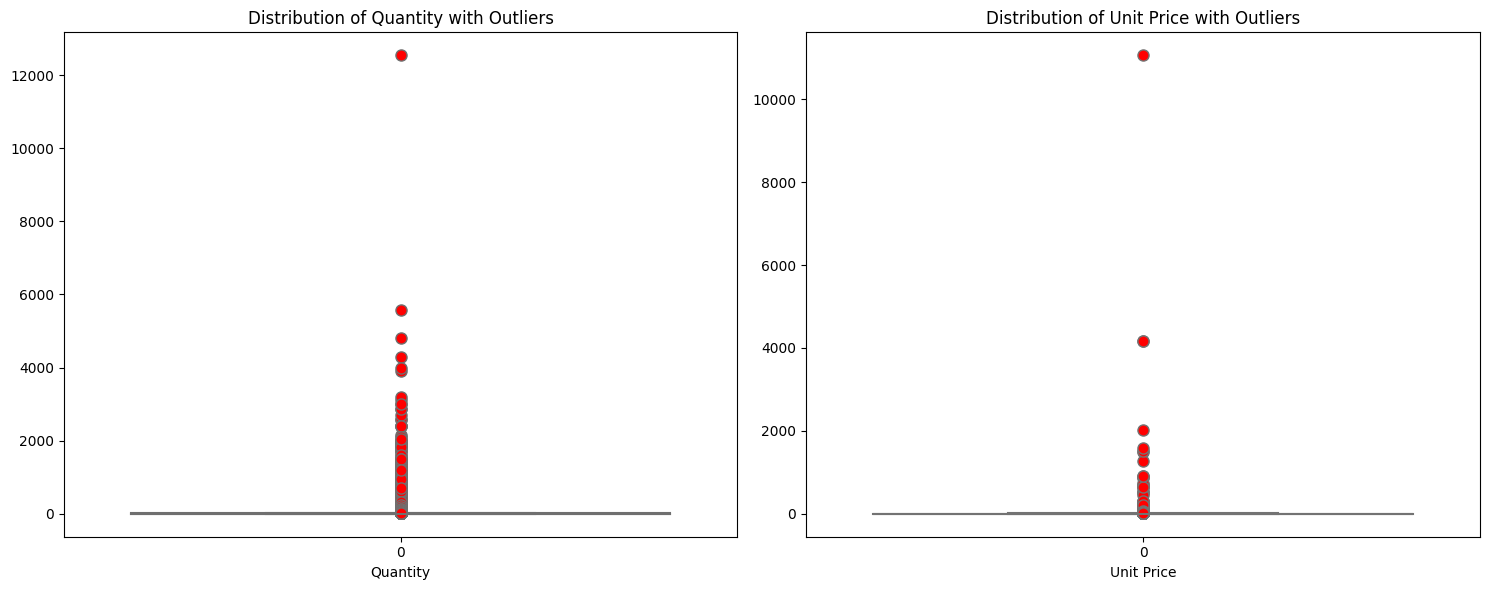

In [8]:
# 1.5 Handling Outliers

# Visualize the distribution of Quantity and UnitPrice to check for outliers
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(transac_data['Quantity'], color='skyblue', flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title('Distribution of Quantity with Outliers')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
sns.boxplot(transac_data['UnitPrice'], color='lightgreen', flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title('Distribution of Unit Price with Outliers')
plt.xlabel('Unit Price')


plt.tight_layout()
plt.show()



# Function to remove outliers using IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Removing outliers from each numerical column
for col in transac_data.select_dtypes(include=['float64', 'int64']).columns:
    transac_data = remove_outliers(transac_data, col)


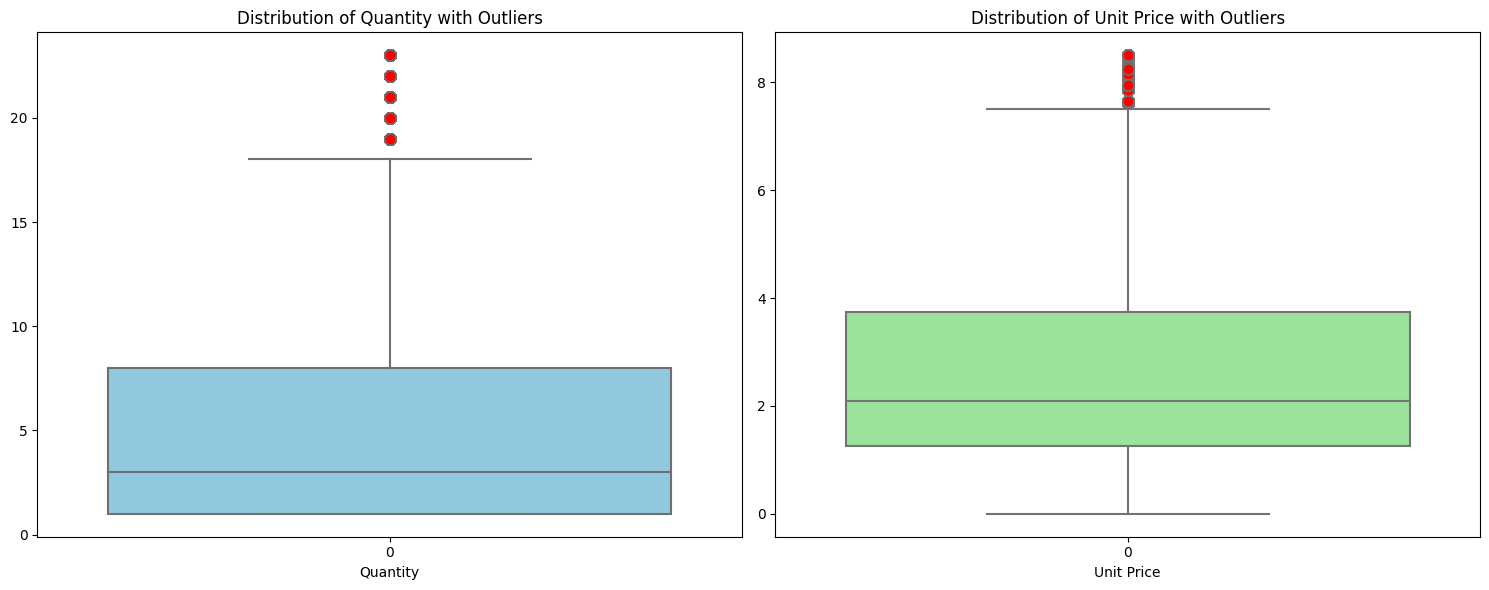

In [9]:
# figure after removing outliers
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(transac_data['Quantity'], color='skyblue', flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title('Distribution of Quantity with Outliers')
plt.xlabel('Quantity')

plt.subplot(1, 2, 2)
sns.boxplot(transac_data['UnitPrice'], color='lightgreen', flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
plt.title('Distribution of Unit Price with Outliers')
plt.xlabel('Unit Price')


plt.tight_layout()
plt.show()

In [10]:
#1.6 Summary Statistics

# Determine the size of the dataset (number of rows and columns)
dataset_size = transac_data.shape
print("Dataset Size (rows, columns):", dataset_size)

# Provide a brief description of each column in the dataset
column_descriptions = transac_data.dtypes
print("\nColumn Descriptions:\n", column_descriptions)


# Generating a brief summary of the dataset
summary = transac_data.describe(include='all', datetime_is_numeric=True)
print("\nSummary: \n", summary)

Dataset Size (rows, columns): (438396, 8)

Column Descriptions:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

Summary: 
        InvoiceNo StockCode                         Description      Quantity  \
count     438396    438396                              438396  438396.00000   
unique     18283      3724                                3804           NaN   
top       573585    85123A  WHITE HANGING HEART T-LIGHT HOLDER           NaN   
freq         956      1860                                1916           NaN   
mean         NaN       NaN                                 NaN       4.91017   
min          NaN       NaN                                 NaN       1.00000   
25%          NaN       NaN                                 NaN       1.00000   
50%          NaN       NaN   

In [11]:
#1.7 Determine the time period covered by the dataset

min_date = transac_data['InvoiceDate'].min()
max_date = transac_data['InvoiceDate'].max()
print("\nTime Period Covered: From", min_date, "to", max_date)


Time Period Covered: From 2010-12-01 08:26:00 to 2011-12-09 12:50:00


**RFM Calculations**

In [12]:
#rfm calculations
df_nn=transac_data.copy()
#dropping unknown customer rows as it doesn't provide any insight
df_nn.drop(df_nn.loc[df_nn['CustomerID'] == 'Unknown Customer'].index, inplace=True)
df_nn['InvoiceDate']=pd.to_datetime(df_nn['InvoiceDate'], errors='coerce')
df_nn['InvoiceDate'] = df_nn['InvoiceDate'].dt.date
df_recency = df_nn.groupby(by='CustomerID',as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']

recent_date = df_recency['LastPurchaseDate'].max()

df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
frequency_df = df_nn.groupby(by='CustomerID',as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
df_nn['Total'] = df_nn['UnitPrice']*df_nn['Quantity']
monetary_df = df_nn.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
df1=df_recency.merge(monetary_df,how='inner',on='CustomerID')
df_RFM=df1.merge(frequency_df,how='inner',on='CustomerID')
rfm_df=df_RFM.copy()
# for a combined rfm value we define weights.
weights = {'Recency': 0.4, 'Frequency': 0.3, 'Monetary': 0.3}

rfm_df['RFM_Combined'] = (rfm_df['Recency'] * weights['Recency'] +
                          rfm_df['Frequency'] * weights['Frequency'] +
                          rfm_df['Monetary'] * weights['Monetary'])

rfm_df['RFM_Quartile'] = pd.qcut(rfm_df['RFM_Combined'], q=4, labels=False) + 1
rfm_df

,CustomerID,LastPurchaseDate,Recency,Monetary,Frequency,RFM_Combined,RFM_Quartile
0,12347.0,2011-12-07,2,2866.77,141,903.131,4
1,12348.0,2011-04-05,248,17.00,1,104.600,1
2,12349.0,2011-11-21,18,1155.75,61,372.225,4
3,12350.0,2011-02-02,310,274.00,15,210.700,3
4,12352.0,2011-11-03,36,971.98,56,322.794,3
...,...,...,...,...,...,...,...
4151,18280.0,2011-03-07,277,160.70,9,161.710,2
4152,18281.0,2011-06-12,180,46.92,5,87.576,1
4153,18282.0,2011-12-02,7,113.13,8,39.139,1
4154,18283.0,2011-12-06,3,2068.98,754,848.094,4


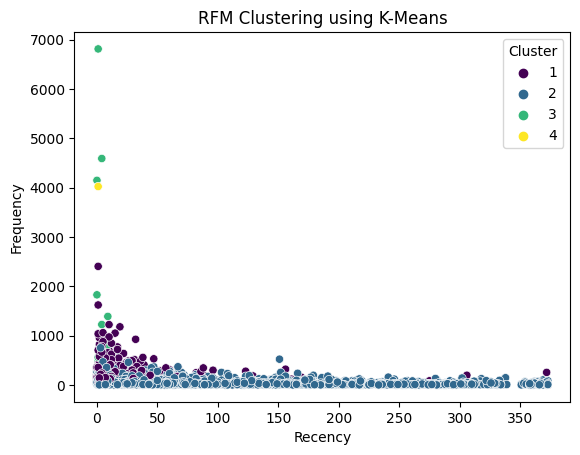

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

rfm_data = rfm_df[['Recency', 'Frequency', 'Monetary']]

num_clusters = 4

# Applying K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_data)+1
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('RFM Clustering using K-Means')

plt.show()

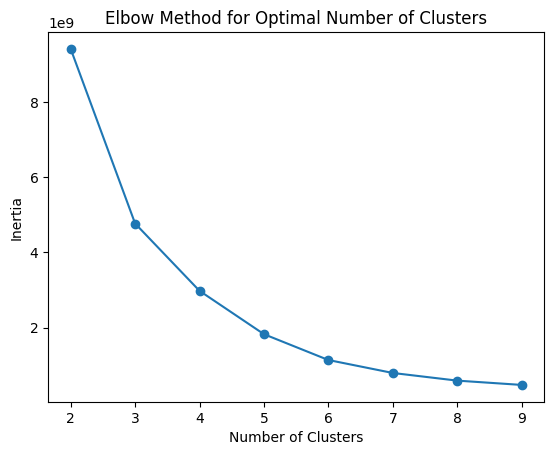

In [14]:
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=10)
    kmeans.fit(rfm_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method to find the optimal number of clusters
plt.plot(range(2,10), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [15]:
# Calculate summary statistics for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'std', 'min', 'max'],
    'Frequency': ['mean', 'std', 'min', 'max'],
    'Monetary': ['mean', 'std', 'min', 'max'],
    # Add other relevant attributes
}).reset_index()

# Display the summary statistics
cluster_summary



Cluster     Recency                         Frequency                     \
                 mean         std min  max         mean          std   min   
0       1   22.773494   37.018428   0  372   279.797590   229.087662    35   
1       2  101.113197  102.233780   0  373    48.115880    58.750974     1   
2       3    4.833333    4.281744   0   11  1948.666667  2088.688555   309   
3       4    1.000000         NaN   1    1  4024.000000          NaN  4024   

             Monetary                                   
    max          mean          std       min       max  
0  2405   3786.841376  1665.159144   2155.02  11120.14  
1   754    553.870738   505.779338      0.00   2164.25  
2  6814  19257.375833  8280.891277  11870.26  38290.66  
3  4024  74816.690000          NaN  74816.69  74816.69

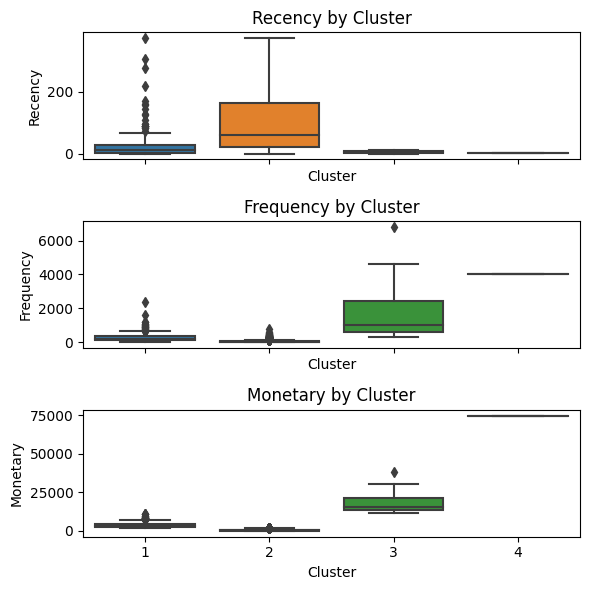

In [16]:
# Visualize RFM scores for each cluster
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
sns.boxplot(x='Cluster', y='Recency', data=rfm_df, ax=axes[0])
sns.boxplot(x='Cluster', y='Frequency', data=rfm_df, ax=axes[1])
sns.boxplot(x='Cluster', y='Monetary', data=rfm_df, ax=axes[2])

# Customize plot
axes[0].set_title('Recency by Cluster')
axes[1].set_title('Frequency by Cluster')
axes[2].set_title('Monetary by Cluster')

plt.tight_layout()
plt.show()

In [17]:
#questons

2. Customer Analysis

In [18]:
# Remove rows that contains 'Unknown Customers' before customer analysis
customer_df = transac_data[transac_data['CustomerID'] != 'Unknown Customer']

In [19]:
#2.1 How many unique customers are there in the dataset?
unique_customers = customer_df['CustomerID'].nunique()
print("Number of Unique Customers:", unique_customers)


Number of Unique Customers: 4156


Distribution of Number of Orders per Customer:
 17841.0    6814
14096.0    4592
12748.0    4149
14911.0    4024
14606.0    2405
           ... 
15423.0       1
17949.0       1
14576.0       1
16162.0       1
16953.0       1
Name: CustomerID, Length: 4156, dtype: int64


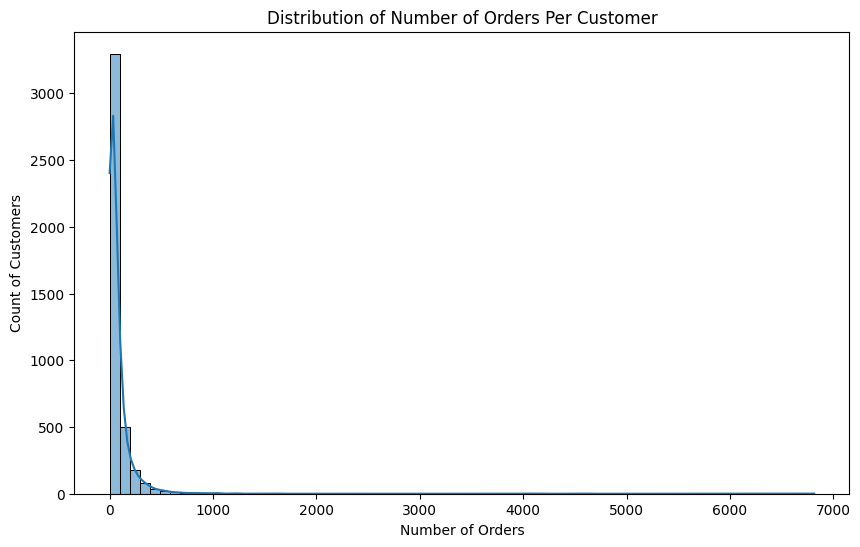

In [20]:
#2.2 What is the distribution of the number of orders per customer?
import matplotlib.pyplot as plt
import seaborn as sns


orders_per_customer= customer_df['CustomerID'].value_counts()
print("Distribution of Number of Orders per Customer:\n", orders_per_customer)


# Visualize the distribution of the number of orders per customer
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_customer, kde=True, bins=70)
plt.title('Distribution of Number of Orders Per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Count of Customers')
plt.show()


Top 5 Customers by Order Count:
 17841.0    6814
14096.0    4592
12748.0    4149
14911.0    4024
14606.0    2405
Name: CustomerID, dtype: int64


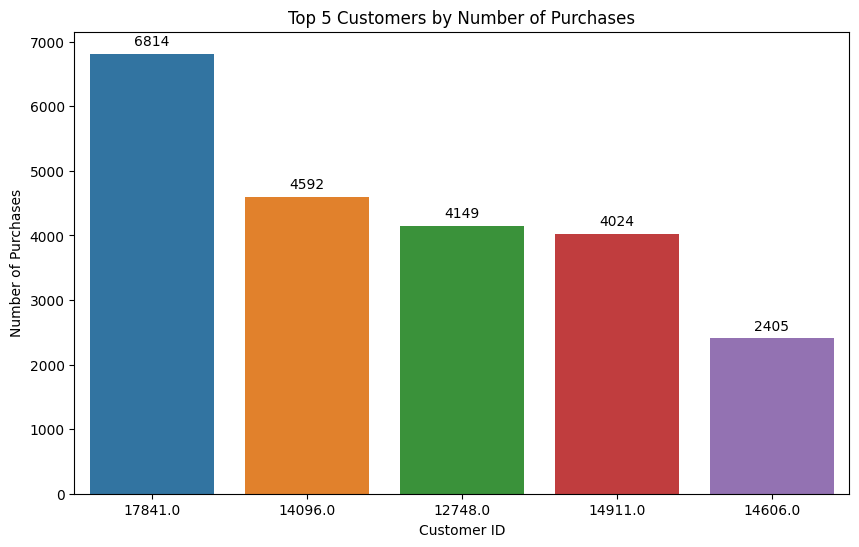

In [21]:
#2.3 Identify the top 5 customers who have made the most purchases by order count
top_5_customers = orders_per_customer.head(5)
print("\nTop 5 Customers by Order Count:\n", top_5_customers)

# Visualize the top 5 customers
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=top_5_customers.index, y=top_5_customers.values)
plt.title('Top 5 Customers by Number of Purchases')
plt.xlabel('Customer ID')
plt.ylabel('Number of Purchases')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')
plt.show()

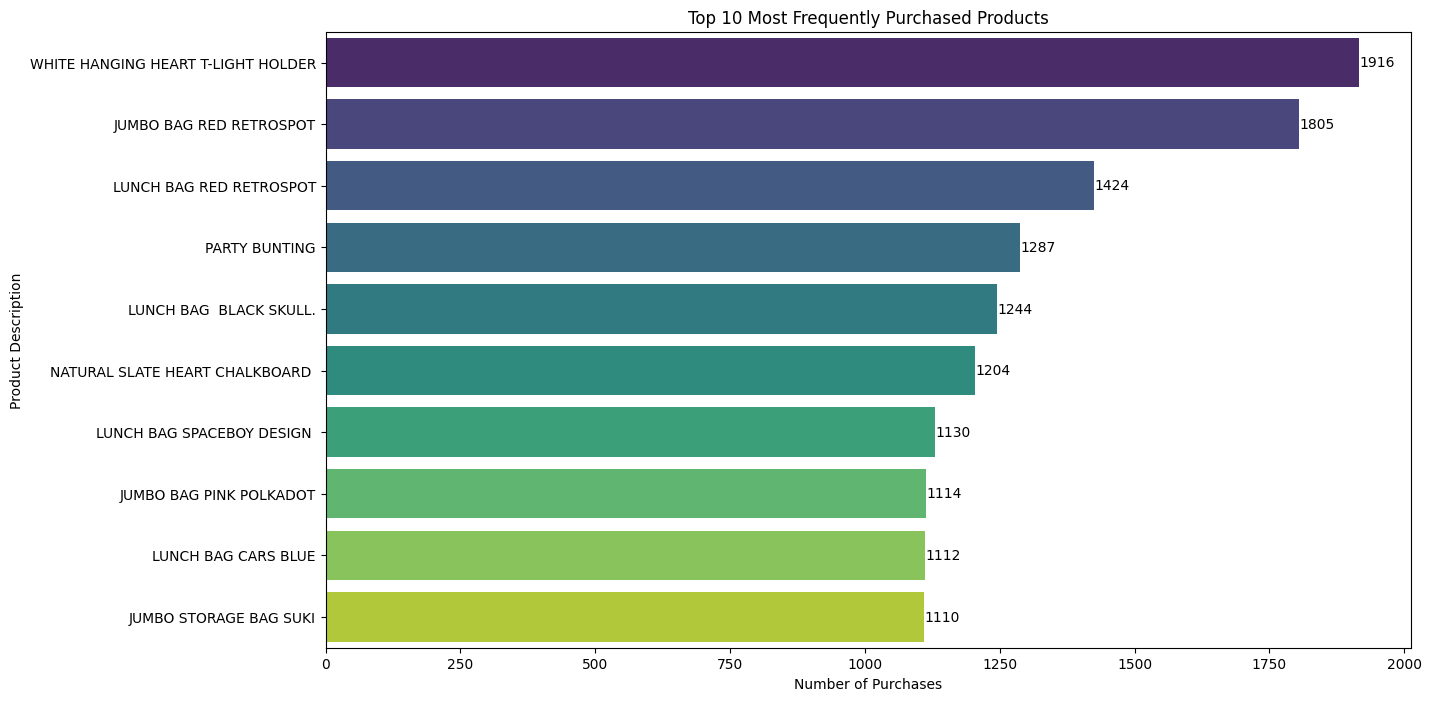

Top 10 Most Frequently Purchased Products:
 WHITE HANGING HEART T-LIGHT HOLDER    1916
JUMBO BAG RED RETROSPOT               1805
LUNCH BAG RED RETROSPOT               1424
PARTY BUNTING                         1287
LUNCH BAG  BLACK SKULL.               1244
NATURAL SLATE HEART CHALKBOARD        1204
LUNCH BAG SPACEBOY DESIGN             1130
JUMBO BAG PINK POLKADOT               1114
LUNCH BAG CARS BLUE                   1112
JUMBO STORAGE BAG SUKI                1110
Name: Description, dtype: int64

Average Price of Products in the Dataset: 2.22

Product Category that Generates the Highest Revenue: PARTY BUNTING

Revenue Generated by the PARTY BUNTING Category: 33819.75


In [22]:
#3. Product Analysis

# 3.1 Find the top 10 most frequently purchased products
top_10_products = transac_data['Description'].value_counts().head(10)
# Visualize the top 10 most frequently purchased products
plt.figure(figsize=(14, 8))
barplot = sns.barplot(y=top_10_products.index, x=top_10_products.values, palette="viridis")
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Description')
for bar in barplot.patches:
    barplot.annotate(format(bar.get_width(), '.0f'),
                     (bar.get_width(), bar.get_y() + bar.get_height() / 2),
                     ha='center', va='center',
                     size=10, xytext=(13, 0),
                     textcoords='offset points')
plt.show()

# 3.2 Calculate the average price of products in the dataset
transac_data['TotalRevenue'] = transac_data['Quantity'] * transac_data['UnitPrice']
average_price = transac_data['TotalRevenue'].sum() / transac_data['Quantity'].sum()

#3.3 Identify the product category that generates the highest revenue
highest_revenue_category = transac_data.groupby('Description')['TotalRevenue'].sum().idxmax()
highest_revenue = transac_data.groupby('Description')['TotalRevenue'].sum().max()

print("Top 10 Most Frequently Purchased Products:\n", top_10_products)
print(f"\nAverage Price of Products in the Dataset: {average_price:.2f}")
print("\nProduct Category that Generates the Highest Revenue:", highest_revenue_category)
print(f"\nRevenue Generated by the {highest_revenue_category} Category: {highest_revenue:.2f}")


In [23]:
transac_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


#4. Time analysis

In [25]:
df=customer_df.copy()

In [26]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [27]:
df['day'] = df['InvoiceDate'].dt.strftime('%A')

In [28]:
df[df['day'] == 'Saturday']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,day


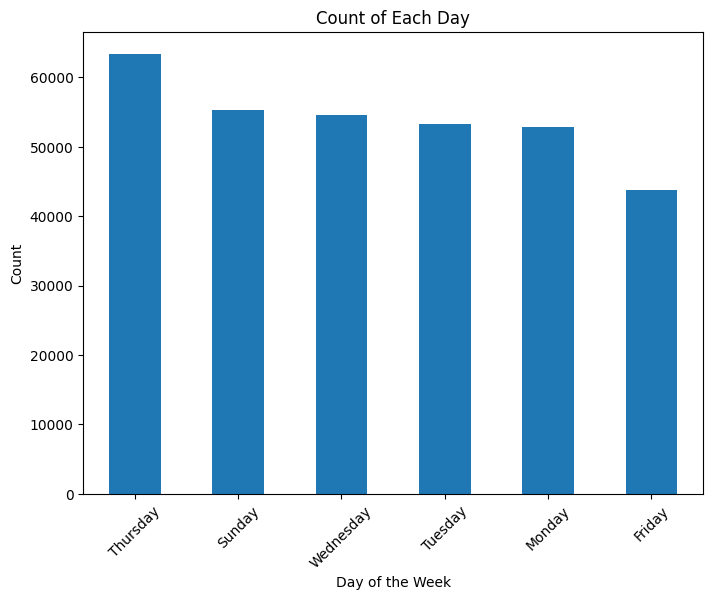

In [29]:
day_counts = df['day'].value_counts()


day_counts.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Count of Each Day')
plt.xticks(rotation=45)
plt.show()

In [30]:
df['Year'] = df['InvoiceDate'].dt.year

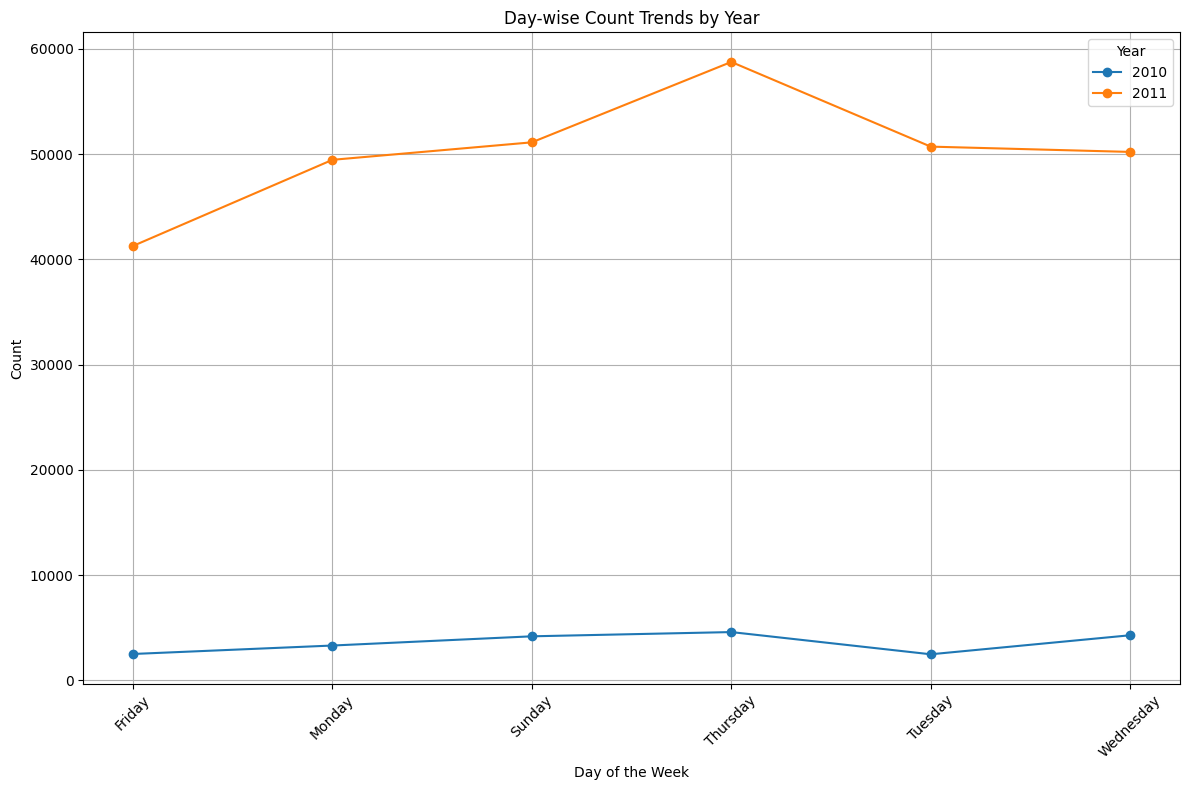

In [31]:
pivot_df = df.groupby(['day', 'Year']).size().reset_index().pivot(index='day', columns='Year', values=0)


pivot_df.plot(kind='line', figsize=(12, 8), marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Day-wise Count Trends by Year')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

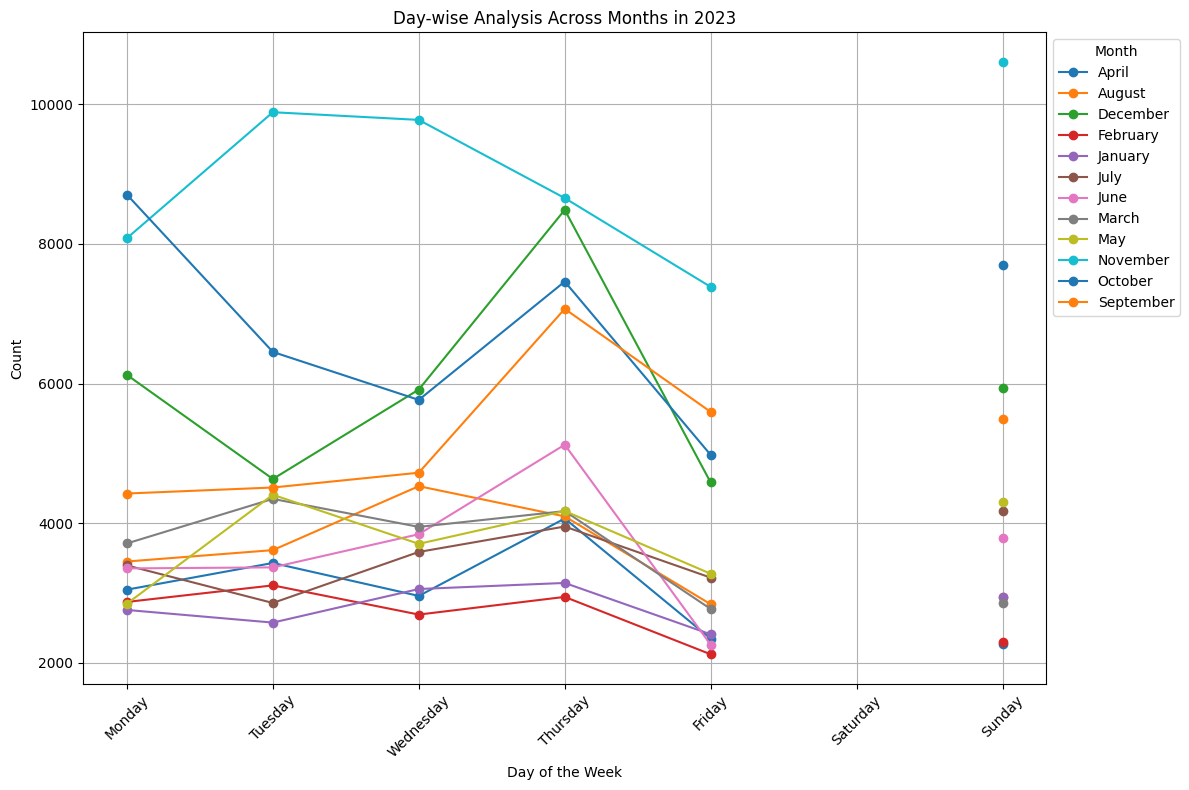

In [32]:
df['Month'] = df['InvoiceDate'].dt.month_name()


pivot_df = df.groupby(['day', 'Month']).size().reset_index().pivot(index='day', columns='Month', values=0)


ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(ordered_days)


pivot_df.plot(kind='line', figsize=(12, 8), marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Day-wise Analysis Across Months in 2023')
plt.legend(title='Month', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

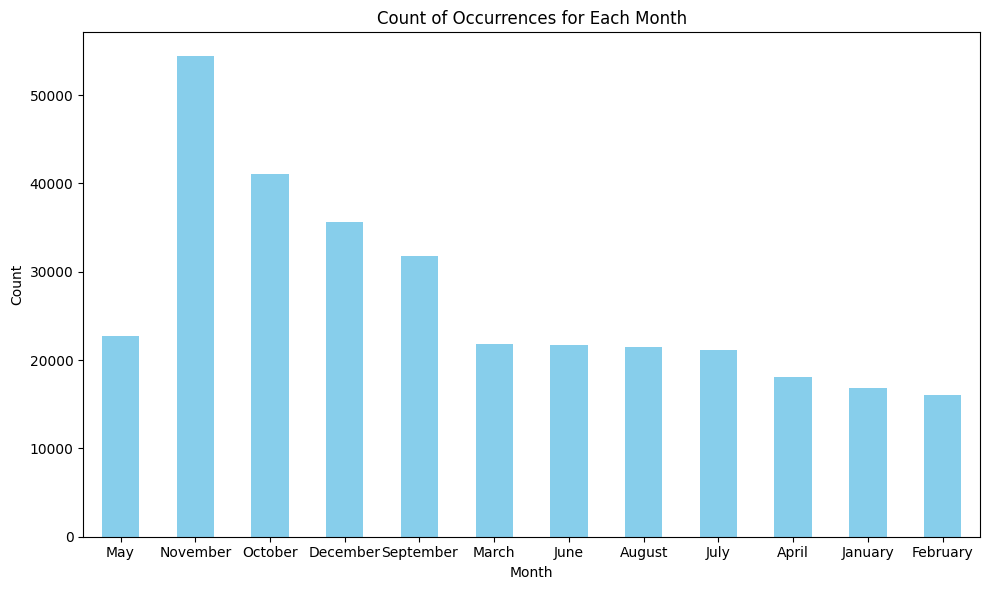

In [33]:
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Count occurrences of each month in the 'Month' column and sort by defined order
month_counts = df['Month'].value_counts().sort_index(key=lambda x: pd.Categorical(x, categories=months_order))

# Increase the horizontal width of the graph
plt.figure(figsize=(10, 6))

# Plotting the count of each month
month_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Occurrences for Each Month')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#5 Geographical Analysis

Top 5 countries with the highest number of orders:
United Kingdom    293027
Germany             6752
France              6249
EIRE                4951
Spain               1908
Name: Country, dtype: int64


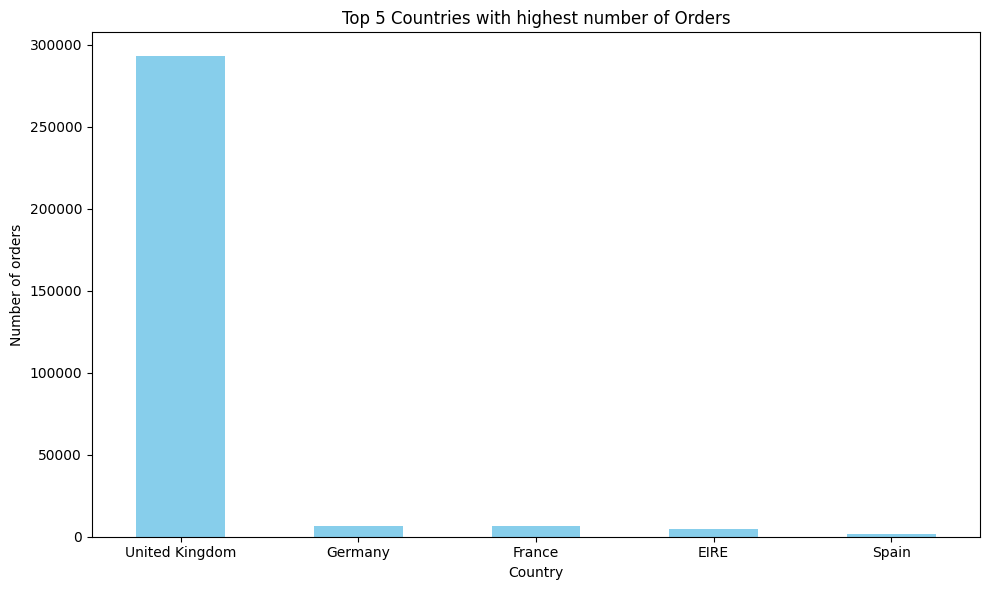

In [35]:
country_counts = df['Country'].value_counts()

top_countries = df['Country'].value_counts().head(5)

print("Top 5 countries with the highest number of orders:")
print(top_countries)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of orders')
plt.title('Top 5 Countries with highest number of Orders')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
df['Total Price'] = df['Quantity'] * df['UnitPrice']

Top 5 countries with the highest total price:
Country
United Kingdom    3392457.864
Germany            125488.510
France             106738.170
EIRE                93646.480
Spain               26939.260
Name: Total Price, dtype: float64


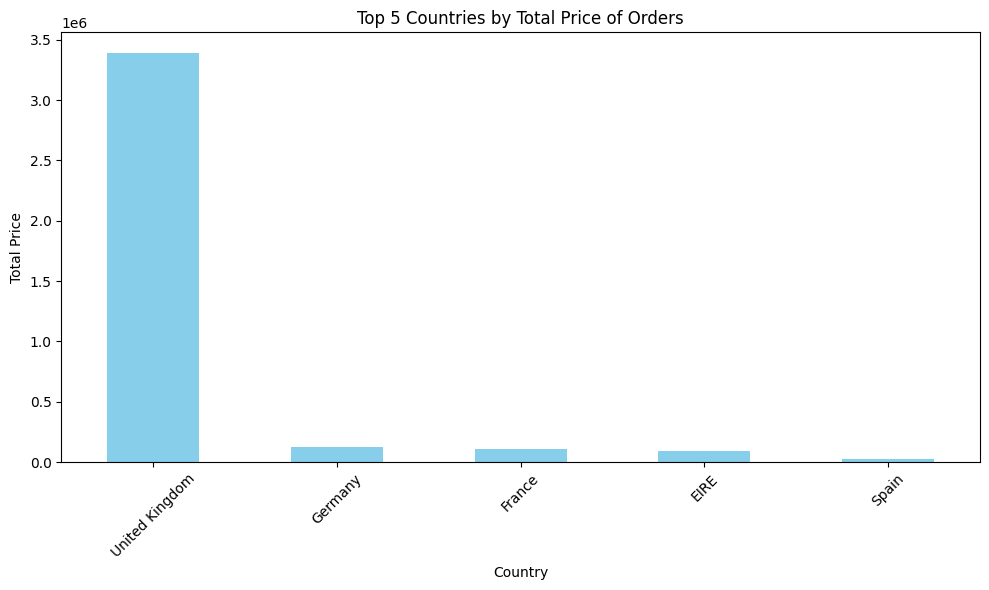

In [37]:

total_price_by_country = df.groupby('Country')['Total Price'].sum()

# Get the top 5 countries with the highest total price
top_5_countries = total_price_by_country.nlargest(5)

print("Top 5 countries with the highest total price:")
print(top_5_countries)
plt.figure(figsize=(10, 6))
top_5_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('Total Price')
plt.title('Top 5 Countries by Total Price of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

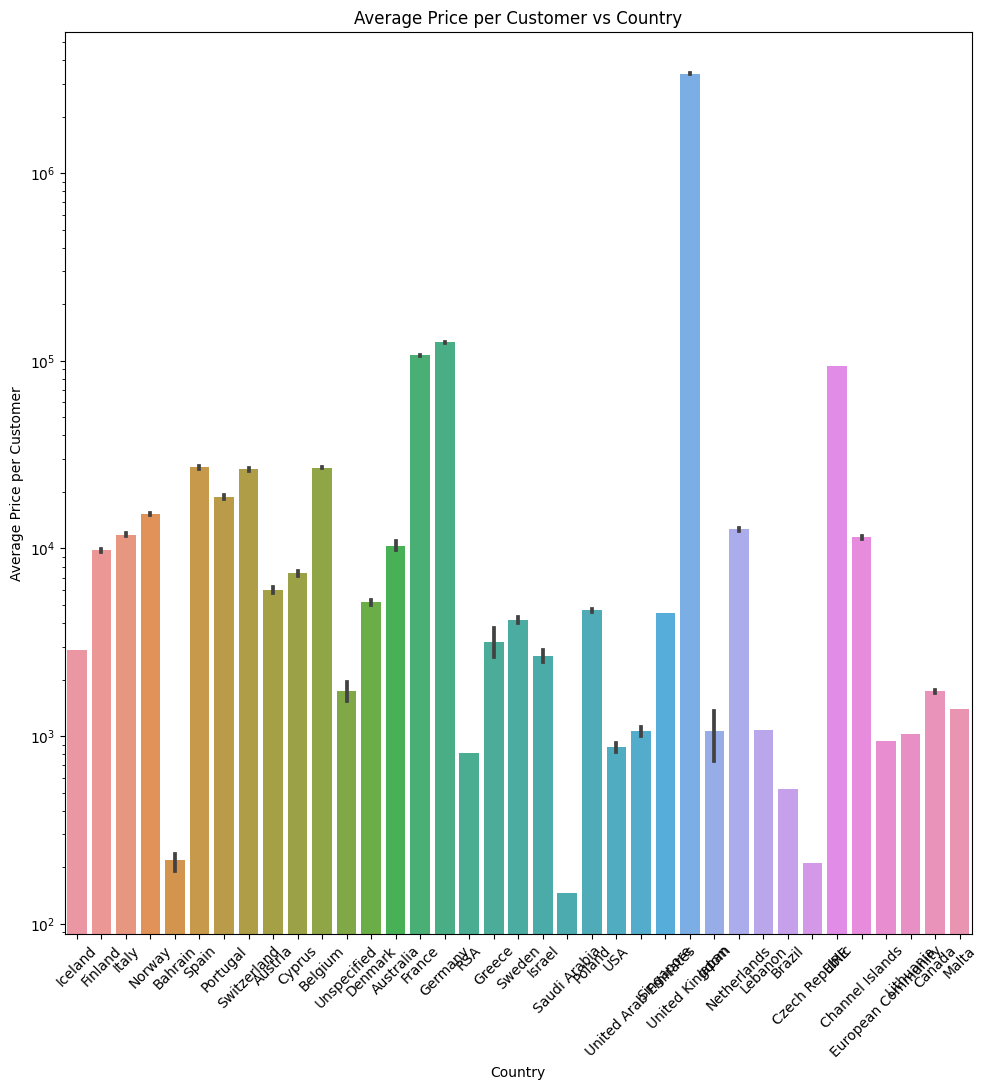

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




avg_price_per_customer = df.groupby('CustomerID')['Total Price'].mean().reset_index()


merged_data = pd.merge(avg_price_per_customer, df[['CustomerID', 'Country']], on='CustomerID', how='inner')

# Visualize the trend using a bar plot
plt.figure(figsize=(10, 11))
sns.barplot(data=merged_data, x='Country', y='Total Price', estimator=sum)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Country')
plt.ylabel('Average Price per Customer')
plt.title('Average Price per Customer vs Country')
plt.tight_layout()
plt.show()

#6. Customer Behavior

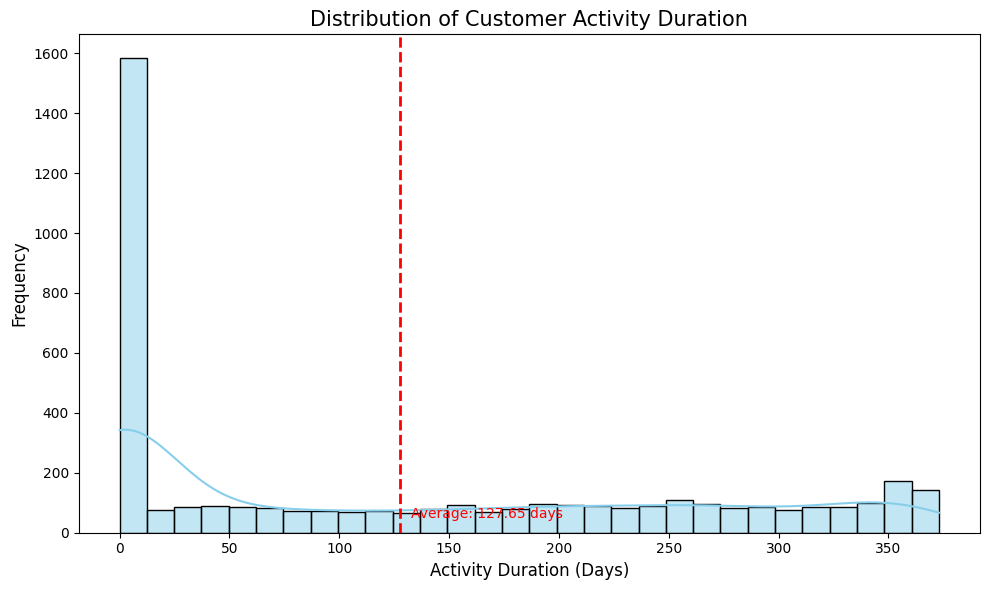

In [39]:

# Convert InvoiceDate to datetime
transac_data['InvoiceDate'] = pd.to_datetime(transac_data['InvoiceDate'])

# Extracting first and last purchase date for each customer
customer_first_purchase = transac_data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
customer_last_purchase = transac_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()

# Merging the two dataframes
customer_activity = pd.merge(customer_first_purchase, customer_last_purchase, on='CustomerID', how='inner')
customer_activity.columns = ['CustomerID', 'FirstPurchaseDate', 'LastPurchaseDate']

# Calculating the duration between first and last purchase in days
customer_activity['ActivityDuration'] = (customer_activity['LastPurchaseDate'] - customer_activity['FirstPurchaseDate']).dt.days

# Calculating the average activity duration
average_activity_duration = customer_activity['ActivityDuration'].mean()

# Visualizing the Customer Activity Duration
plt.figure(figsize=(10, 6))
activity_duration_plot = sns.histplot(customer_activity['ActivityDuration'], bins=30, kde=True, color='skyblue')
activity_duration_plot.set_title('Distribution of Customer Activity Duration', fontsize=15)
activity_duration_plot.set_xlabel('Activity Duration (Days)', fontsize=12)
activity_duration_plot.set_ylabel('Frequency', fontsize=12)
plt.axvline(average_activity_duration, color='red', linestyle='dashed', linewidth=2)
plt.text(average_activity_duration + 5, 50, f'Average: {average_activity_duration:.2f} days', color = 'red')
plt.tight_layout()
plt.show()


In [40]:
#8. Returns and Refunds
# Filter returns based on 'Quantity' less than 0 and 'InvoiceNo' starting with 'C'
returns = data[(data['Quantity'] < 0) & (data['InvoiceNo'].str.startswith('C'))]
percentage_returns = (len(returns) / len(data)) * 100
percentage_returns

1.7139409015166756

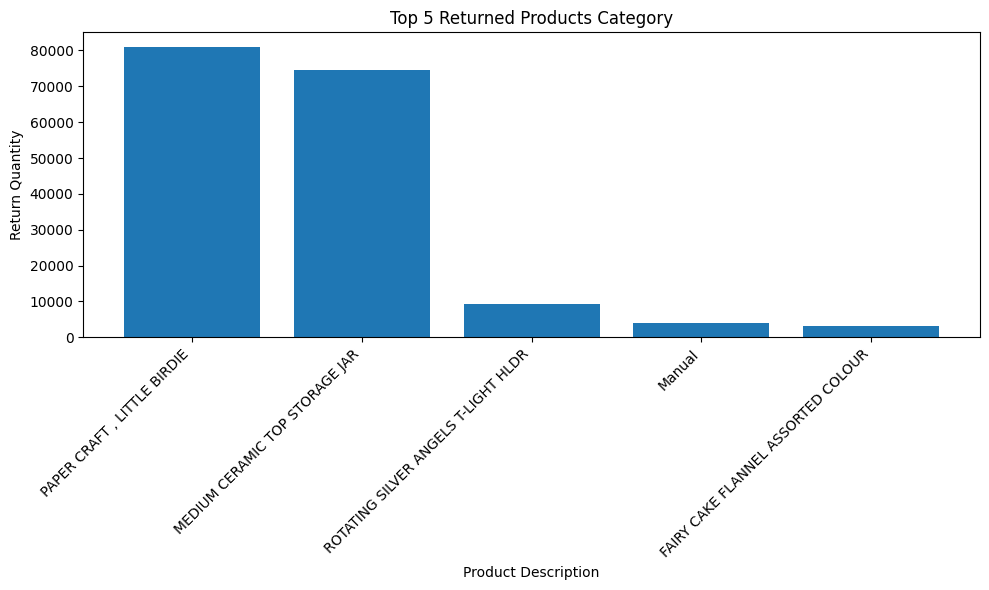

In [41]:
# Group by product (Description) and calculate return quantities
return_quantities = returns.groupby('Description')['Quantity'].sum().reset_index()

# Take the absolute value of return quantities
return_quantities['Quantity'] = abs(return_quantities['Quantity'])

# Sort by return quantities in descending order and select the top 5
top_5_returns = return_quantities.sort_values(by='Quantity', ascending=False).head(5)

# Create a bar chart to visualize the top 5 returned products
plt.figure(figsize=(10, 6))
plt.bar(top_5_returns['Description'], top_5_returns['Quantity'])
plt.xlabel('Product Description')
plt.ylabel('Return Quantity')
plt.title('Top 5 Returned Products Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#9. Profitability Analysis

Total Revenue Generated by the Company: 4788851.55

Top 5 Most Profitable Products:
 Description
PARTY BUNTING                         33819.75
WHITE HANGING HEART T-LIGHT HOLDER    33655.32
JUMBO BAG RED RETROSPOT               32016.72
SPOTTY BUNTING                        22671.55
JAM MAKING SET WITH JARS              22443.06
Name: TotalRevenue, dtype: float64


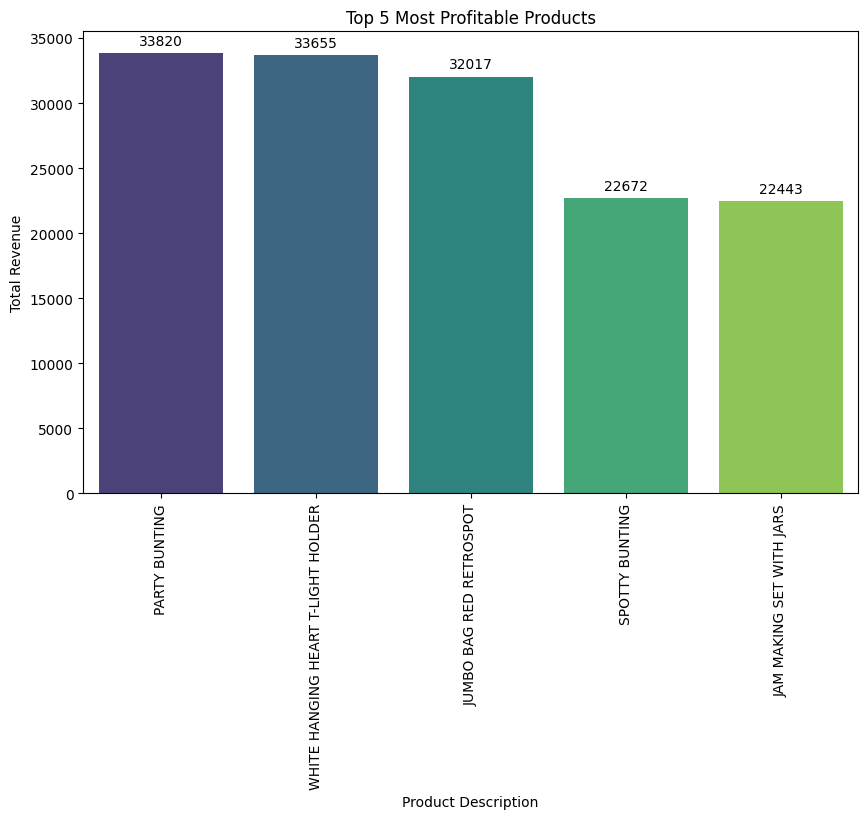

In [42]:

# 9.1 Calculate the total revenue generated by the company
total_revenue = transac_data['TotalRevenue'].sum()


print(f"Total Revenue Generated by the Company: {total_revenue:.2f}")

# top 5 most profitable products
top_5_profitable_products = transac_data.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(5)
print("\nTop 5 Most Profitable Products:\n", top_5_profitable_products)

# Visualize the top 5 most profitable products
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=top_5_profitable_products.index, y=top_5_profitable_products.values, palette="viridis")
plt.title('Top 5 Most Profitable Products')
plt.xlabel('Product Description')
plt.xticks(rotation=90)
plt.ylabel('Total Revenue')
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.0f'),
                     (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')
plt.show()

#10. Customer Satisfaction

<ipython-input-43-dd1c3ec51ccd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancellations['InvoiceDate'] = pd.to_datetime(cancellations['InvoiceDate'])


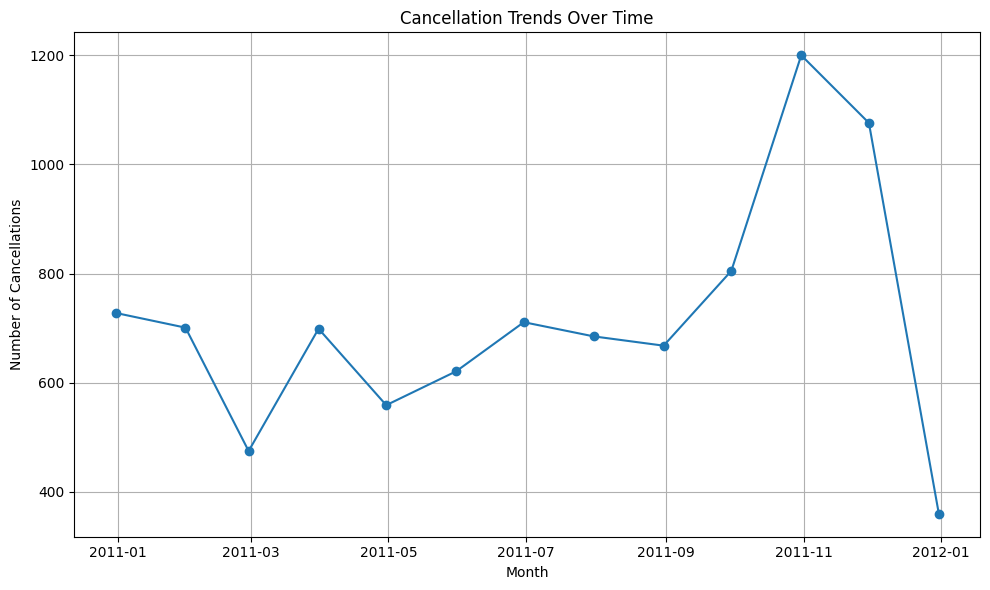

In [43]:

cancellations = data[data['InvoiceNo'].str.startswith('C')]

# Convert 'InvoiceDate' to datetime
cancellations['InvoiceDate'] = pd.to_datetime(cancellations['InvoiceDate'])

# Group cancellations by month and count the number of cancellations in each month
cancellations_by_month = cancellations.resample('M', on='InvoiceDate')['InvoiceNo'].count()

# Create a line chart to visualize cancellation trends over time
plt.figure(figsize=(10, 6))
plt.plot(cancellations_by_month.index, cancellations_by_month.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.title('Cancellation Trends Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

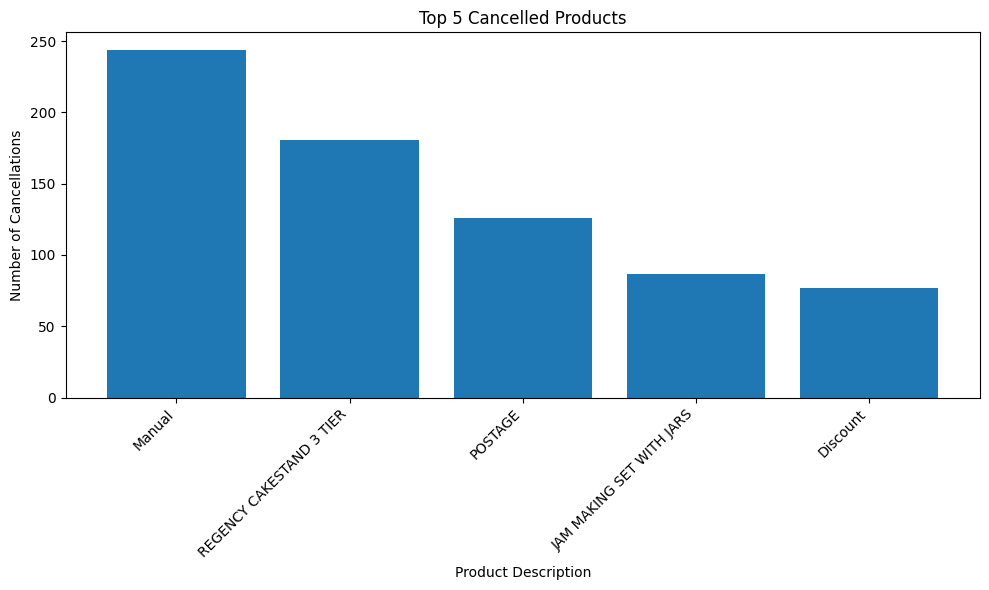

In [44]:
# Group cancellations by product (Description) and count the number of cancellations for each product
top_cancelled_products = cancellations.groupby('Description')['InvoiceNo'].count().reset_index()

# Sort by the number of cancellations in descending order and select the top 5
top_5_cancelled_products = top_cancelled_products.sort_values(by='InvoiceNo', ascending=False).head(5)

# Display the top 5 cancelled products
top_5_cancelled_products

# Create a bar chart to visualize the top 5 cancelled products
plt.figure(figsize=(10, 6))
plt.bar(top_5_cancelled_products['Description'], top_5_cancelled_products['InvoiceNo'])
plt.xlabel('Product Description')
plt.ylabel('Number of Cancellations')
plt.title('Top 5 Cancelled Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()